Dieses Jupyter Notebook umfasst eine Datenmodellierung zur Berechnung der erwarteten individuellen Schadenshöhe von Versicherungsnehmern, basierend auf deren jeweiligen Risikomermalen.

Vorgehensweise:
Die erwarteten Kosten E(X) werden als Erwartungswert operationalisiert. Hierbei werden die individuellen Häufigkeiten von Schadensfällen *f(x_n)* pro Jahr und die erwarteten individuellen Schadenshöhen *x_n* geschätzt.

$\frac{E(X)}{Jahr} = \sum \limits _{n=1}^{N} \frac{f(x_n)}{Jahr} * x_n$

Die Werte für beide Terme werden mit Generalized Linear Models ermittelt. Hierbei wird $\frac{f(x_n)}{Jahr}$ mit einem Poisson Rate Model geschätzt, $x_n$ anhand eines Log-Normal Regressionsmodells. Bei den verwendeten Daten handelt es sich um zwei Datensätze eines französischen Versicherungsunternehmens. Die Datensätze sind [hier](https://www.openml.org/search?type=data&sort=runs&id=41214) und [hier](https://www.openml.org/search?type=data&sort=runs&id=41215) herunterladbar. Die Datensätze enthalten Daten über Versicherungsverträge, gemeldeter Schadensfälle, angefallene Schadenshöhen, sowie kundenspezifische Details, welche als Risikofaktoren identifizierbar sind.

Für beide Modelle (und Datensätze) werden die Schritte Explorative Datenanalyse, Feature Engineering und Modellvergleich getrennt abgehandelt. Dabei werden jeweilige Erkenntnisse aus den Prozessen vermerkt. Schließlich werden die Modelle mit der höchsten prädiktiven Performance ausgewählt und im finalen Schritt, der Modellierung, angewendet und genauer untersucht.

In [1]:
import pandas as pd
import arff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Poisson Regression

### Explorative Datenanalyse
Learnings:
1. Keine missing values, dtypes float und objects
2. Verteilungen der Messwerte wird bei Feature Engineering berücksichtigt
3. Abhängige Variable CountRate (ClaimNb/Exposure) ist zero-inflated. Könnte für ein zero-inflated model sprechen.
4. Sehr niedrige Korrelationen der unabhängigen Variablen mit der abhängigen Variable ClaimRate.

In [2]:
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])

def Checkdf(df):
    print("Info")
    print(df.info(),"\n\n")
    print("Missing values\n",df.isnull().sum(),"\n\n")
    print("Unique values\n",df.nunique(),"\n\n")

Checkdf(df_freq)

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB
None 


Missing values
 IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64 


Unique valu

              IDpol        ClaimNb       Exposure       VehPower  \
count  6.780130e+05  678013.000000  678013.000000  678013.000000   
mean   2.621857e+06       0.053247       0.528750       6.454631   
std    1.641783e+06       0.240117       0.364442       2.050906   
min    1.000000e+00       0.000000       0.002732       4.000000   
25%    1.157951e+06       0.000000       0.180000       5.000000   
50%    2.272152e+06       0.000000       0.490000       6.000000   
75%    4.046274e+06       0.000000       0.990000       7.000000   
max    6.114330e+06      16.000000       2.010000      15.000000   

              VehAge        DrivAge     BonusMalus        Density  
count  678013.000000  678013.000000  678013.000000  678013.000000  
mean        7.044265      45.499122      59.761502    1792.422405  
std         5.666232      14.137444      15.636658    3958.646564  
min         0.000000      18.000000      50.000000       1.000000  
25%         2.000000      34.000000      50.000

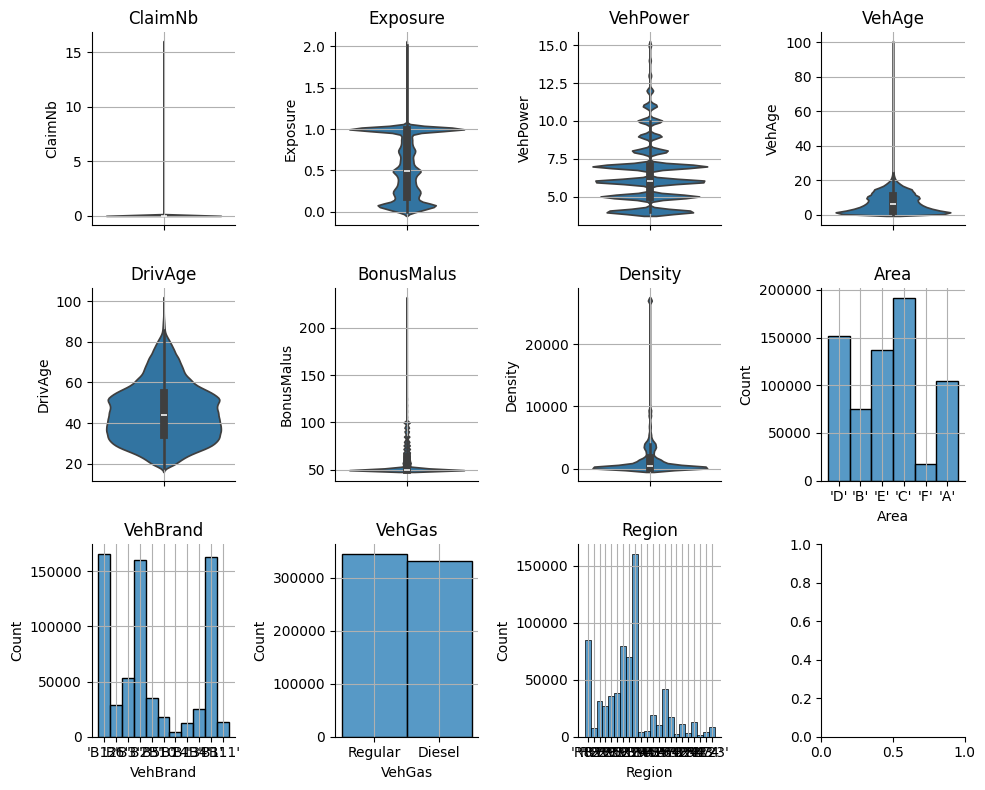

In [3]:
print(df_freq.describe())

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes = axes.flatten()

numericVariables = df_freq.drop('IDpol',axis=1).select_dtypes(include='float64').columns
lenNum = len(numericVariables)
categoricalVariables = df_freq.select_dtypes(include='object').columns

# plot violinplots for numeric variables
for i, ax in enumerate(axes[:lenNum]):
    var = numericVariables[i]
    sns.violinplot(data=df_freq[var],ax=ax)
    ax.set_title(var)
    ax.grid(True)

# plot histograms for categorical variables
for i, ax in enumerate(axes[lenNum:-1]):
    var = categoricalVariables[i]
    sns.histplot(data=df_freq[var],ax=ax)
    sns.despine()
    ax.set_title(var)
    ax.grid(True)

plt.tight_layout()

# Show the plot
plt.show()

count    678013.000000
mean          0.263964
std           4.593915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         732.000000
Name: ClaimRate, dtype: float64


Text(0.5, 1.0, 'Histogram of ClaimRate and Poisson PMF')

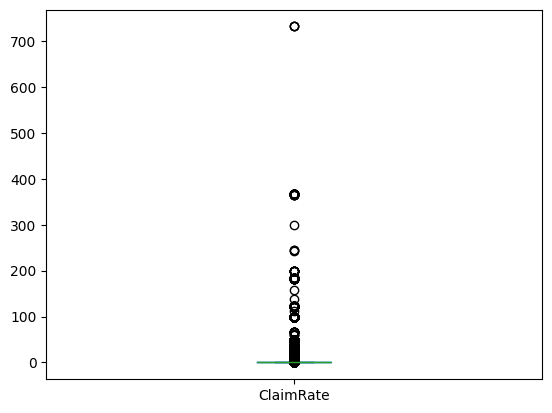

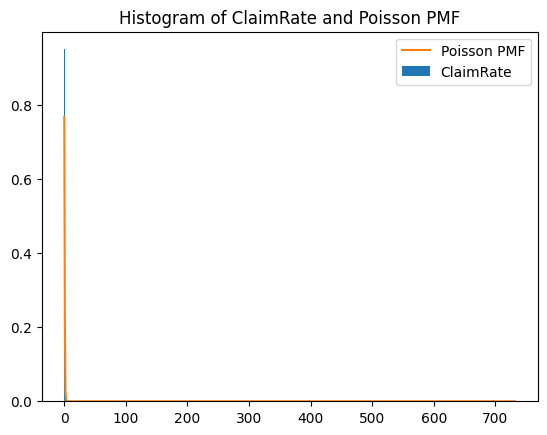

In [4]:
# Check boxplot of dependent variable ClaimRate
df_freq["ClaimRate"] = df_freq.ClaimNb/df_freq.Exposure
df_freq.ClaimRate.plot.box()
plt.figure()

# Check alignment with Poisson Probability Mass Function
import scipy.stats as stats
print(df_freq.ClaimRate.describe())
plt.hist(df_freq.ClaimRate,density=True,bins=732)
plt.plot(stats.poisson.pmf(np.arange(0,733),mu=df_freq.ClaimRate.describe()["mean"]))
plt.legend(["Poisson PMF","ClaimRate"])
plt.title("Histogram of ClaimRate and Poisson PMF")

<Axes: >

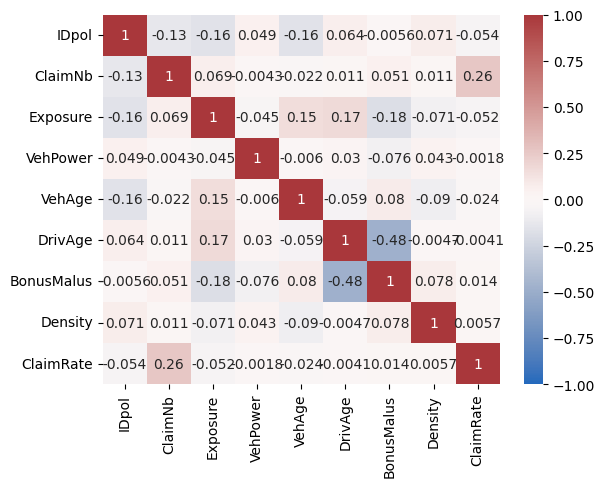

In [5]:
sns.heatmap(df_freq.drop(categoricalVariables,axis=1).corr(),vmin=-1, vmax=1,cmap='vlag',annot=True)

# Feature Engineering
1. Kategorische Daten werden zu dummy-Variablen transformiert.
2. Numerische Daten werden z-transformiert (Bessere Interpretierbarkeit und Handhabung). Density wird auch log-transformiert (um sehr hohe Werte handzuhaben)

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,drop='first') 
categorical_encoded_data = encoder.fit_transform(df_freq[categoricalVariables])

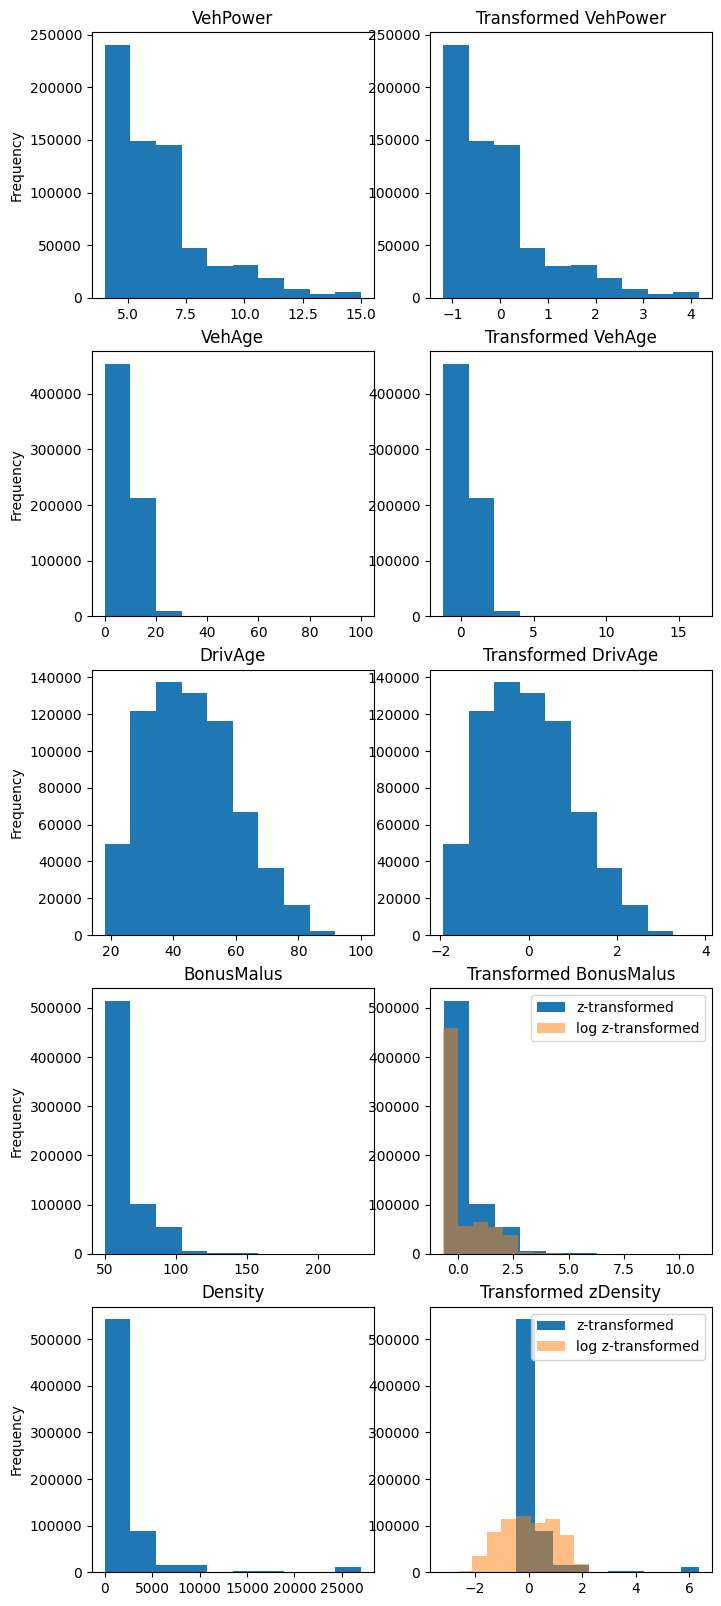

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

def ZTransformation(data):
    scaler = StandardScaler()
    scaler.fit(data.values.reshape(-1,1))
    return scaler.transform(data.values.reshape(-1,1))

fig, axes = plt.subplots(5, 2, figsize=(8,20))
axes = axes.flatten()

df_freq.VehPower.plot.hist(ax=axes[0])
zVehPower = ZTransformation(df_freq.VehPower)
axes[1].hist(zVehPower)
axes[0].set_title("VehPower")
axes[1].set_title("Transformed VehPower")

df_freq.VehAge.plot.hist(ax=axes[2])
zVehAge = ZTransformation(df_freq.VehAge)
axes[3].hist(zVehAge)
axes[2].set_title("VehAge")
axes[3].set_title("Transformed VehAge")

df_freq.DrivAge.plot.hist(ax=axes[4])
zDrivAge = ZTransformation(df_freq.DrivAge)
axes[5].hist(zDrivAge)
axes[4].set_title("DrivAge")
axes[5].set_title("Transformed DrivAge")

df_freq.BonusMalus.plot.hist(ax=axes[6])
zBonusMalus = ZTransformation(df_freq.BonusMalus)
axes[7].hist(zBonusMalus)
logZBonusMalus = ZTransformation(np.log(df_freq.BonusMalus))
axes[7].hist(logZBonusMalus,alpha=.5)
axes[6].set_title("BonusMalus")
axes[7].set_title("Transformed BonusMalus")
axes[7].legend(["z-transformed","log z-transformed"])

df_freq.Density.plot.hist(ax=axes[8])
zDensity = ZTransformation(df_freq.Density)
axes[9].hist(zDensity)
logZDensity = ZTransformation(np.log(df_freq.Density))
axes[9].hist(logZDensity,alpha=.5)

axes[8].set_title("Density")
axes[9].set_title("Transformed zDensity")
axes[9].legend(["z-transformed","log z-transformed"])

In [8]:
X = np.concatenate((np.ones(len(df_freq)).reshape(-1,1),zVehPower, zVehAge,
                    zDrivAge,zBonusMalus,logZDensity,categorical_encoded_data),
                   axis=1)

variable_names = ['Intercept',"zVehPower","zVehAge","zDrivAge","zBonusMalus","logZDensity",
                       "Area_'B'", "Area_'C'", "Area_'D'", "Area_'E'", "Area_'F'",
                       "VehBrand_'B10'", "VehBrand_'B11'", "VehBrand_'B12'",
                       "VehBrand_'B13'", "VehBrand_'B14'", "VehBrand_'B2'",
                       "VehBrand_'B3'", "VehBrand_'B4'", "VehBrand_'B5'", "VehBrand_'B6'",
                       'VehGas_Regular', "Region_'R21'", "Region_'R22'", "Region_'R23'",
                       "Region_'R24'", "Region_'R25'", "Region_'R26'", "Region_'R31'",
                       "Region_'R41'", "Region_'R42'", "Region_'R43'", "Region_'R52'",
                       "Region_'R53'", "Region_'R54'", "Region_'R72'", "Region_'R73'",
                       "Region_'R74'", "Region_'R82'", "Region_'R83'", "Region_'R91'",
                       "Region_'R93'", "Region_'R94'"]

### Modellvergleich
In dieser Sektion werden verschiedene Modelle gefitted und metrik-basiert verglichen. 

Das letztendliche Ziel der Modellierung ist die Vorhersage von adäquaten Preisen von Versicherungsprämien. Es handelt sich also um einen Prediction task, bei dem die prädiktive Qualität des Modells zentral ist. Daher wird hier der Root Mean Squared Error (RMSE) herangezogen. Hierbei handelt es sich um eine einfach zu interpretierende Metrik, die die Abweichung von Modell-Vorhersagen zu tatsächlichen Messwerten widerspiegelt. Je niedriger der RMSE, desto besser sagt das Modell erwartbare Werte vorher. 

Da die erwarteten Kosten die Grundlage für zukünftige Versicherungsprämien sind, soll das finale Modell zukünftige Daten vorhersagen können. Daher wird ein train-test split angewandt, um die Vorhersagbarkeit des Modells auf neue Daten einzuschätzen.

Modelle:
1. Baseline Poisson model: Schätzt CountRate als Intercept einer Poisson Regression
2. Informed Poisson model: Inkludiert alle verfügbaren Regressoren. Dieses Modell weist die höchste prädiktive Performance auf und wird daher für die finale Modellierung verwendet.
3. Baseline Zero Inflated model: Schätzt CountRate als Intercept einer Zero Inflated Regression
4. Informed Zero Inflated model: Inkludiert alle verfügbaren Regressoren. Hierbei gab es Convergence Issues. Von einer aufwändigeren Analyse wurde mit Hinblick auf die Instruktionen abgesehen.

In [9]:
from sklearn.model_selection import train_test_split

y=df_freq.ClaimNb.values
expos = df_freq.Exposure.values
X_train, X_test, y_train, y_test, expos_train, expos_test = train_test_split(X, y,expos, test_size=0.2, random_state=1337)

# storing train and test X data as dataframe easens overview in statsmodels
X_train_df = pd.DataFrame(data=X_train,columns=variable_names)
X_test_df = pd.DataFrame(data=X_test,columns=variable_names)

In [ ]:
import statsmodels.api as sm

baseline_poisson_model = sm.GLM(y_train, X_train_df.Intercept,exposure = expos_train, family=sm.families.Poisson()).fit()
informed_poisson_model = sm.GLM(y_train, X_train_df, family=sm.families.Poisson(),exposure=expos_train).fit()
baseline_zero_inflated_model = sm.ZeroInflatedPoisson(y_train, X_train_df.Intercept, exposure =expos_train).fit()
informed_zero_inflated_model = sm.ZeroInflatedPoisson(y_train, X_train_df,exposure =expos_train).fit() 

In [11]:
from sklearn.metrics import root_mean_squared_error
def CalculateRMSE(model,exoge,exposu,y_t):
    y_pred = model.predict(exog=exoge,exposure=exposu)
    return root_mean_squared_error(y_t,y_pred)
    
print("RMSE baseline poisson model:       ", CalculateRMSE(baseline_poisson_model,X_test_df.Intercept,expos_test,y_test))
print("RMSE informed poisson model:       ", CalculateRMSE(informed_poisson_model,X_test_df,expos_test,y_test))
print("RMSE baseline zero inflated model: ", CalculateRMSE(baseline_zero_inflated_model,X_test_df.Intercept.values,expos_test,y_test))
print("RMSE informed zero inflated model: ", CalculateRMSE(informed_zero_inflated_model,X_test_df,expos_test,y_test))

RMSE baseline poisson model:        0.2390438466766175
RMSE informed poisson model:        0.23785683417629097
RMSE baseline zero inflated model:  0.23909401926386706
RMSE informed zero inflated model:  0.23793410476975838


# Log Regression Model

### Exploratory Data Analysis
1. Erstelle DataFrame df_merged, der Prädiktoren aus df_freq in df_sev einfügt. 
2. Auffälligkeit: 195 missing values entdeckt. Diese gehen auf 6 Versicherungen zurück, die nicht in df_freq enthalten waren. Da es hierfür keine Prädiktoren gibt, wurden diese Daten aus der Analyse ausgeschlossen.
3. Die Prädiktoren wurden bereits für das Poisson Modell untersucht. Daher wird hier ein Fokus auf die abhängige Variable ClaimAmount gelegt. Verteilung hat starke positive Skewness, daher könnte eine Log-Normal Regression angebracht sein. Sehr niedrige Korrelationen mit numerischen Prädiktorvariablen.

In [12]:
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol","ClaimAmount"])

df_merged = df_sev.merge(df_freq, on='IDpol', how='left')
Checkdf(df_merged)

ids_to_drop = df_merged[df_merged.ClaimNb.isnull()].IDpol.unique()
df_merged = df_merged[~df_merged['IDpol'].isin(ids_to_drop)]

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
 2   ClaimNb      26444 non-null  float64
 3   Exposure     26444 non-null  float64
 4   Area         26444 non-null  object 
 5   VehPower     26444 non-null  float64
 6   VehAge       26444 non-null  float64
 7   DrivAge      26444 non-null  float64
 8   BonusMalus   26444 non-null  float64
 9   VehBrand     26444 non-null  object 
 10  VehGas       26444 non-null  object 
 11  Density      26444 non-null  float64
 12  Region       26444 non-null  object 
 13  ClaimRate    26444 non-null  float64
dtypes: float64(10), object(4)
memory usage: 2.8+ MB
None 


Missing values
 IDpol            0
ClaimAmount      0
ClaimNb        195
Exposure       195
Area           195
VehPower       195
VehAge         195
Driv

count    2.644400e+04
mean     2.265513e+03
std      2.937103e+04
min      1.000000e+00
25%      6.859925e+02
50%      1.172000e+03
75%      1.212385e+03
max      4.075401e+06
Name: ClaimAmount, dtype: float64


<Axes: title={'center': 'Log transformed ClaimAmount'}>

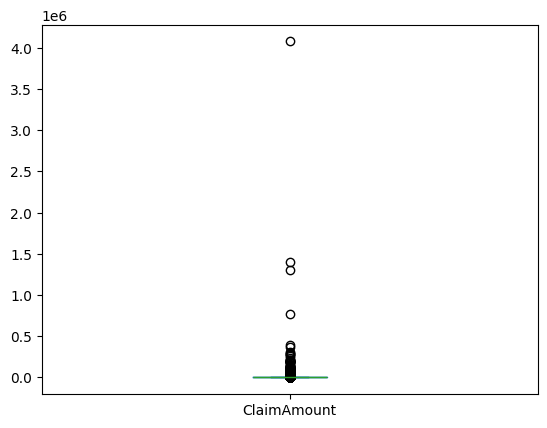

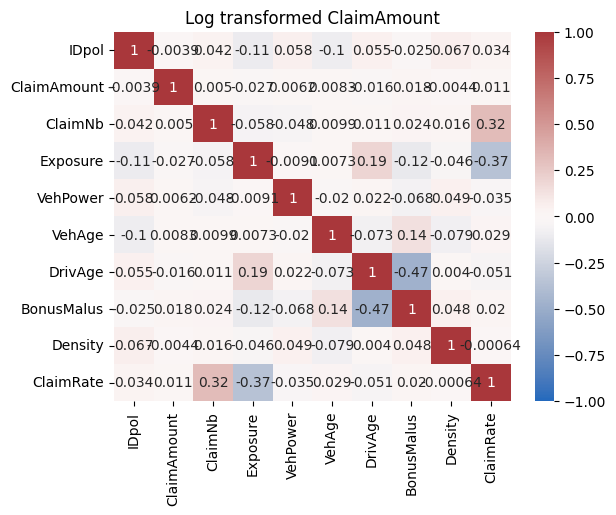

In [13]:
df_merged.ClaimAmount.plot.box()
print(df_merged.ClaimAmount.describe())
plt.figure()
plt.hist(np.log(df_merged.ClaimAmount))
plt.title("Log transformed ClaimAmount")

sns.heatmap(df_merged.drop(categoricalVariables,axis=1).corr(),vmin=-1, vmax=1,cmap='vlag',annot=True)

### Feature Engineering
1. Transformation (siehe Poisson Regression für Details)

In [14]:
categorical_encoded_data_m = encoder.fit_transform(df_merged[categoricalVariables])
zVehPower_m = ZTransformation(df_merged.VehPower)
zVehAge_m = ZTransformation(df_merged.VehAge)
zDrivAge_m = ZTransformation(df_merged.DrivAge)
zBonusMalus_m = ZTransformation(df_merged.BonusMalus)
logZDensity_m = ZTransformation(np.log(df_merged.Density))

X_m = np.concatenate((np.ones(len(df_merged)).reshape(-1,1),zVehPower_m, zVehAge_m,
                    zDrivAge_m,zBonusMalus_m,logZDensity_m,categorical_encoded_data_m),
                   axis=1)

variable_names = ['Intercept',"zVehPower","zVehAge","zDrivAge","zBonusMalus","logZDensity",
                       "Area_'B'", "Area_'C'", "Area_'D'", "Area_'E'", "Area_'F'",
                       "VehBrand_'B10'", "VehBrand_'B11'", "VehBrand_'B12'",
                       "VehBrand_'B13'", "VehBrand_'B14'", "VehBrand_'B2'",
                       "VehBrand_'B3'", "VehBrand_'B4'", "VehBrand_'B5'", "VehBrand_'B6'",
                       'VehGas_Regular', "Region_'R21'", "Region_'R22'", "Region_'R23'",
                       "Region_'R24'", "Region_'R25'", "Region_'R26'", "Region_'R31'",
                       "Region_'R41'", "Region_'R42'", "Region_'R43'", "Region_'R52'",
                       "Region_'R53'", "Region_'R54'", "Region_'R72'", "Region_'R73'",
                       "Region_'R74'", "Region_'R82'", "Region_'R83'", "Region_'R91'",
                       "Region_'R93'", "Region_'R94'"]

y_m = df_merged.ClaimAmount.values

### Modellvergleich
Gleiches Prozedere, wie beim Poisson Modell. RMSE und train-test-split.

Modelle
1. Baseline LogNormal Modell: Lineare Regression mit log-transformierten ClaimAmount Werten. Nur Intercept.
2. Informed LogNormal Modell: Lineare Regression mit log-transformierten ClaimAmount Werten und sämtlichen Regressoren. Dieses Modell hat den geringsten RMSE und wird für die finale Modellierung ausgewählt.
3. Gamma Modell: Gamma Regressionsmodell mit sämtlichen Prädiktoren.

In [15]:
X_m_train, X_m_test, y_m_train, y_m_test,  = train_test_split(X_m, y_m, test_size=0.2, random_state=1337)
X_m_train_df = pd.DataFrame(data=X_m_train,columns=variable_names)
X_m_test_df = pd.DataFrame(data=X_m_test,columns=variable_names)

In [ ]:
baseline_lognormal_model = sm.OLS(np.log(y_m_train), X_m_train_df.Intercept).fit()
informed_lognormal_model = sm.OLS(np.log(y_m_train), X_m_train_df).fit()
gamma_model = sm.GLM(np.log(y_m_train),  X_m_train_df, family=sm.families.Gamma()).fit()

In [17]:
def CalculateRMSE_m(model,exoge,y_t):
    y_pred = model.predict(exog=exoge)
    return root_mean_squared_error(y_t,y_pred)
print("RMSE baseline lognormal model: ", root_mean_squared_error(y_m_test,np.exp(baseline_lognormal_model.predict(exog=X_m_test_df.Intercept))))
print("RMSE informed lognormal model: ", root_mean_squared_error(y_m_test,np.exp(informed_lognormal_model.predict(exog=X_m_test_df))))
print("RMSE gamma model:              ", CalculateRMSE_m(gamma_model,X_m_test_df,y_m_test))

RMSE baseline lognormal model:  21970.013390128424
RMSE informed lognormal model:  21969.375163221608
RMSE gamma model:               22045.844729302516


# Modellierung
1. Expected Cost wird aus den multiplizierten vorhergesagten Werten des Poisson und LogNormal Modells berechnet. Es zeigen sich einige Ausreißerwerte. Insgesamt ist eine Variablität der erwarteten Kosten erkennbar. Daher können günstigere Tarife für Versicherte angeboten werden, die geringere Risikofaktoren haben. Grundsätzliche Bedingung für einen fairen individuellen Beitrag ist gegeben.
2. Anhand der Metrik Ratio(ActualCost/ExpectedCost) wird das Gesamtergebnis der Modellierung quantifiziert. Das Modell nimmt knapp 30% der Gesamtkosten an, die pro Jahr angefallen sind. Sowohl ClaimRate, als auch ClaimAmount werden gleichermaßen unterschätzt. Der Bias lässt sich nicht hauptsächlich einem Modell zuordnen.
3. Korrelationsanalysen deuten auf mehrere Zusammenhänge der Variablen hin. Daran lassen sich mehrere Risikofaktoren identifizieren.

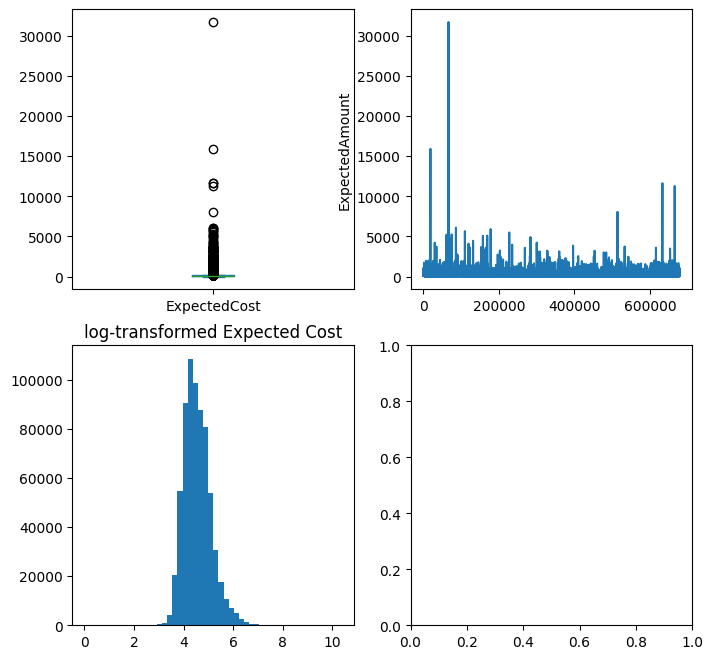

In [18]:
df_freq["ExpectedCount"]= informed_poisson_model.predict(X)
df_freq["ExpectedAmount"]=np.exp(informed_lognormal_model.predict(X))
df_freq["ExpectedCost"]=df_freq.ExpectedCount*df_freq.ExpectedAmount

fig, axes = plt.subplots(2, 2, figsize=(8,8))
axes = axes.flatten()

df_freq.ExpectedCost.plot.box(ax=axes[0])

plt.Figure()
df_freq.ExpectedCost.plot(ax=axes[1])
axes[1].set_ylabel('ExpectedAmount')

plt.Figure()
axes[2].hist(np.log(df_freq.ExpectedCost),bins=50);
axes[2].set_title('log-transformed Expected Cost');

In [19]:
expectedCost = df_freq.ExpectedCost.sum()
annualCost = np.sum(df_merged.ClaimAmount/df_merged.Exposure)
print("Ratio expectedCost/annualCost = ", expectedCost/annualCost)
print("Ratio ExpectedCount/ClaimRate:    ", df_freq.ExpectedCount.sum()/df_freq.ClaimRate.sum())
print("Ratio ExpectedAmount/ClaimAmount: ", np.sum(np.exp(informed_lognormal_model.predict(X_m)))/df_merged.ClaimAmount.sum())

Ratio expectedCost/annualCost =  0.2957426357915805
Ratio ExpectedCount/ClaimRate:     0.41156946141139206
Ratio ExpectedAmount/ClaimAmount:  0.41981730081172886


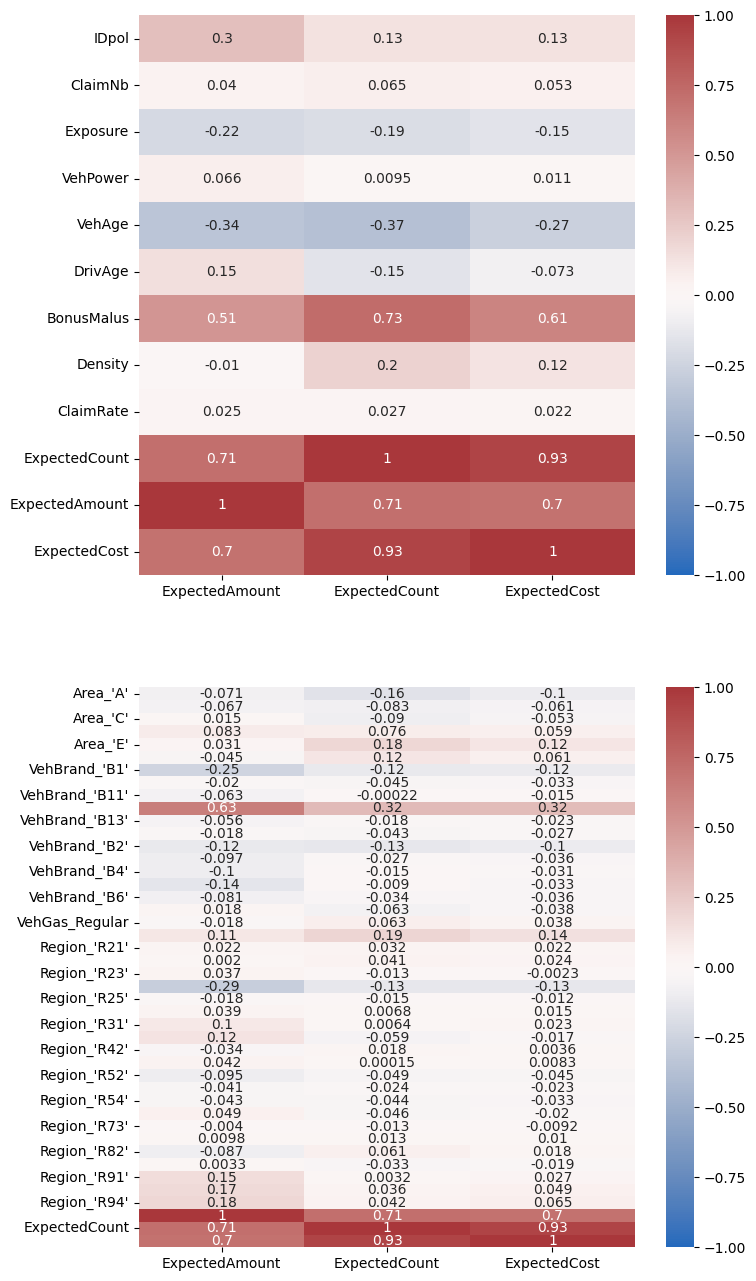

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(8,16))
axes = axes.flatten()
corr_table = df_freq.drop(categoricalVariables,axis=1).corr()[["ExpectedAmount","ExpectedCount","ExpectedCost"]]
sns.heatmap(corr_table,vmin=-1, vmax=1,cmap='vlag',annot=True,ax=axes[0]);

encoder_r = OneHotEncoder(sparse_output=False) 
categorical_encoded_data_r = encoder_r.fit_transform(df_freq[categoricalVariables])
df_categoricalData = pd.DataFrame(data = categorical_encoded_data_r, columns=encoder_r.get_feature_names_out())
df_categoricalData[["ExpectedAmount","ExpectedCount","ExpectedCost"]]=df_freq[["ExpectedAmount","ExpectedCount","ExpectedCost"]]
corr_table_cat = df_categoricalData.corr()[["ExpectedAmount","ExpectedCount","ExpectedCost"]]
sns.heatmap(corr_table_cat,vmin=-1, vmax=1,cmap='vlag',annot=True,ax=axes[1]);